In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetMobile

with tf.device('/CPU:0'):
    from tensorflow.keras import models
    from tensorflow.keras import layers
    import os
    import tensorflow as tf
    from keras.preprocessing.image import ImageDataGenerator
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


    base_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/fc558092/code/Users/fc55809/image_splits_MELandBEN_fin"
    train_dir = os.path.join(base_dir, 'Training')
    test_dir = os.path.join(base_dir, 'Testing')
    validate_dir = os.path.join(base_dir, 'validate')

    img_size=224
    
    xception=Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    nasnet = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    InceptionV3=InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    
    
    models = [xception, vgg16, resnet, nasnet, MobileNetV2,InceptionV3]
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range = 0.1 ,
        horizontal_flip=False,
        channel_shift_range=.001
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
                      batch_size=16,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validate_dir,
        target_size=(img_size, img_size),
        batch_size=16,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=16,
        class_mode='binary')

    model_input = tf.keras.Input(shape=(img_size, img_size, 3))
    
    outputs = [model(model_input) for model in models]
    pooled_outputs = [tf.keras.layers.GlobalAveragePooling2D()(output) for output in outputs]
    dense_outputs = [tf.keras.layers.Dense(256, activation='relu')(pooled_output) for pooled_output in pooled_outputs]
    dropout_outputs = [tf.keras.layers.Dropout(0.3)(dense_output) for dense_output in dense_outputs]
    dense_outputs_2 = [tf.keras.layers.Dense(128, activation='relu')(dropout_output) for dropout_output in dropout_outputs]
    avg = tf.keras.layers.Concatenate()(dense_outputs_2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(avg)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=output, name='ensemble')
    


    

    from tensorflow.keras import metrics
    

    import tensorflow_addons as tfa

    
    f_beta_score = tfa.metrics.FBetaScore(num_classes=1,threshold=0.5,beta=2.0)
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=2e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True,
        name="Adam")

    ensemble_model.compile(optimizer=opt,
                           loss='binary_crossentropy', 
                           metrics=[metrics.Recall(),metrics.Precision(),'accuracy', metrics.AUC(name = 'AUC'),metrics.AUC(curve='PR', name = 'PR-AUC')
                       ,metrics.FalsePositives(), metrics.FalseNegatives(), metrics.TrueNegatives(),metrics.TruePositives(),f_beta_score])
    from tensorflow.keras.callbacks import ModelCheckpoint

    checkpoint = ModelCheckpoint('best_ensemble_concat_supernn.h5', monitor='val_fbeta_score', verbose=1,
                                 save_best_only=True, mode='max')

    # Train the ensemble model
    epochs = 10
    

    history = ensemble_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
        callbacks=[checkpoint]
    )





2023-05-08 18:09:59.489088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 18:10:10.694240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-08 18:10:10.694370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-08 18:10:10.694381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Num GPUs Available:  0
Found 12166 images belonging to 2 classes.
Found 1539 images belonging to 2 classes.
Found 1521 images belonging to 2 classes.
Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
761/761 [==============================] - 10205s 13s/step - loss: 0.4446 - recall: 0.7952 - precision: 0.7689 - accuracy: 0.7882 - AUC: 0.8720 - PR-AUC: 0.8537 - false_positives: 1388.0000 - false_negatives: 1189.0000 - true_negatives: 4971.0000 - true_positives: 4618.0000 - fbeta_score: 0.7898 - val_loss: 0.5339 - val_recall: 0.4841 - val_precision: 0.9102 - val_accuracy: 0.7238 - val_AUC: 0.8721 - val_PR-AUC: 0.8692 - val_false_positives: 36.0000 - val_false_negatives: 389.0000 - val_true_negatives: 749.0000 - val_true_positives: 365.0000 - val_fbeta_score: 0.5341
Epoch 2/10
761/761 [==============================] - 1

In [ ]:
ensemble_model.save('big-super-nn-v2concat_lmao_modelo.h5')


Found 1521 images belonging to 2 classes.
191/191 [==============================] - 325s 2s/step
Accuracy: 0.8540
weighedPrecision_: 0.8557
Precision_: 0.8160
weighedRecall: 0.8540
Recall: 0.8602
F1 Score: 0.8544
F2 score: 0.8509372210651592
Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.85      0.87       856
    Melanoma       0.82      0.86      0.84       665

    accuracy                           0.85      1521
   macro avg       0.85      0.85      0.85      1521
weighted avg       0.86      0.85      0.85      1521



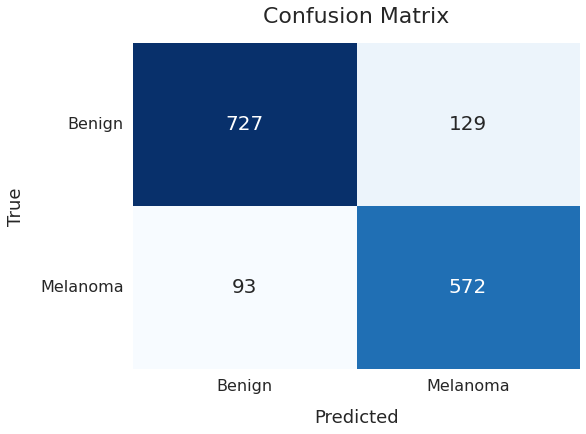

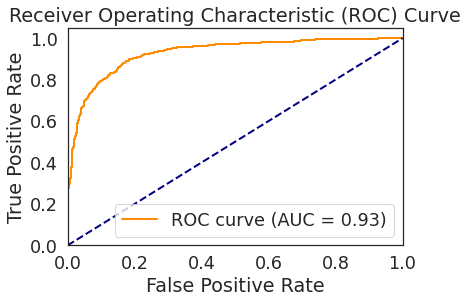

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=8,
    class_mode='binary',shuffle=False,
    seed=42)
y_pred=ensemble_model.predict(test_generator)
y_test=test_generator.classes
y_pred_labels = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

precisionw = precision_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels)
print(f"weighedPrecision_: {precisionw:.4f}")
print(f"Precision_: {precision:.4f}")

recallw = recall_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels)

print(f"weighedRecall: {recallw:.4f}")
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred_labels, average='weighted')
print(f"F1 Score: {f1:.4f}")


def f_beta_score(precision, recall, beta):
    numerator = (1 + beta**2) * (precision * recall)
    denominator = (beta**2 * precision) + recall
    f_beta = numerator / denominator if denominator != 0 else 0
    return f_beta
beta=2
f2_score = f_beta_score(precision, recall, beta)
print(f'F2 score: {f2_score}')
from sklearn.metrics import classification_report

target_names = ['Benign', 'Melanoma']

report = classification_report(y_test, y_pred_labels, target_names=target_names)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


labels = ["Benign", "Melanoma"]
title = "Confusion Matrix"


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.set_style("white")


cmap = sns.color_palette("Blues", as_cmap=True)


ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})

plt.xlabel("Predicted", fontsize=18, labelpad=15)
plt.ylabel("True", fontsize=18, labelpad=15)
plt.title(title, fontsize=22, pad=20)

ax.set_xticklabels(labels, fontsize=16)
ax.set_yticklabels(labels, fontsize=16, rotation=0)


plt.show()
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [9]:
import matplotlib.pyplot as plt

f_beta_score  = history.history['f_beta_score']
val_fbeta_score = history.history['val_fbeta_score']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, f_beta_score, 'bo', label='Training acc')
plt.plot(epochs, val_fbeta_score, 'b', label='Validation acc')
plt.title('Training and validation f_beta_score')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


NameError: name 'history' is not defined